In [1]:
import sys        
sys.path.append('../')   

import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
import astropy.units as u
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic, UnitSystem
from gala.dynamics import mockstream as ms
import astropy.coordinates as coord
_ = coord.galactocentric_frame_defaults.set('v4.0')
from astropy.constants import G
import agama
import run_falcon as run
import torch
import PytorchSpline as spline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import splev, splrep
from tqdm.notebook import tqdm
import MainFunctions


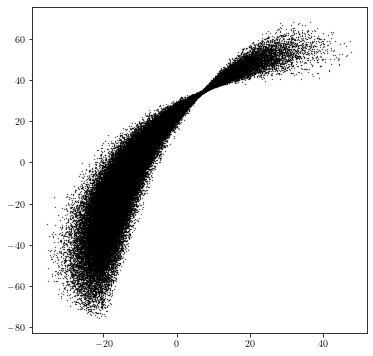

In [34]:
q = 0.8
time = 7.125

file_path = '../../q_' + str(q)
file_name = '/out_t' + str(time)
snap = run.readSnapshot(file_path + file_name ,0.0015)
pos_vel_init = np.load(file_path + '/init_conds_' + str(q) + '.npy')
x_stream, z_stream = snap.pos[:,0], snap.pos[:,2]




Mass_Halo = 6e11*u.Msun
r_s_halo = 16*u.kpc
v_c_halo = (np.sqrt(2.0*G*Mass_Halo/r_s_halo)).to(u.km/u.s)
ext_pot = gp.LogarithmicPotential(v_c=v_c_halo,r_h=r_s_halo,q3=q,units=galactic)
prog_w0 = gd.PhaseSpacePosition(pos=pos_vel_init[:3]*u.kpc,
                                 vel=pos_vel_init[3:]*u.km/u.s)


fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)

ax.scatter(x_stream,z_stream,rasterized=True,color='k',s=0.1)


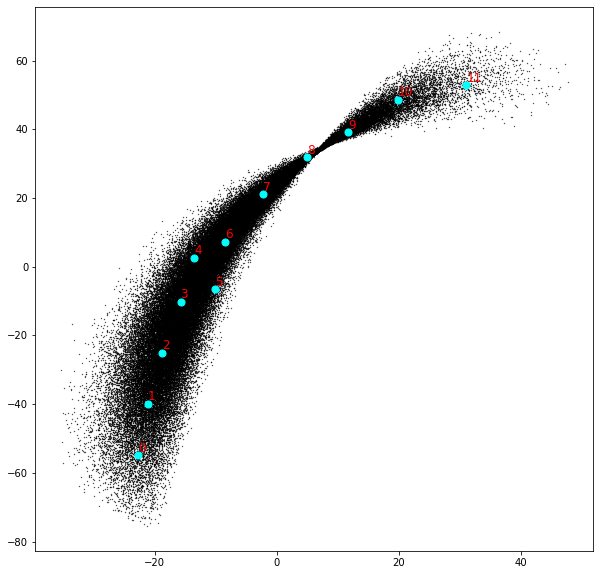

In [3]:
plot_index = True
remove_inds = False
n_bins_x = 5 #5
n_bins_y = 10 #5

remove_inds_list = [12,15,18,21,22,20,27,33]

bins_x = np.linspace(-30,45,n_bins_x)
bins_z = np.linspace(-80,60,n_bins_y)
count_thresh = 800#100


hist_x = stats.binned_statistic_2d(x_stream,z_stream, x_stream, 'mean', bins=[bins_x,bins_z])
hist_z = stats.binned_statistic_2d(x_stream,z_stream, z_stream, 'mean', bins=[bins_x,bins_z])

count_hist = stats.binned_statistic_2d(x_stream,z_stream, None, 'count', bins=[bins_x,bins_z])

x_binned = hist_x[0].flatten()
z_binned = hist_z[0].flatten()
count_bins = count_hist[0].flatten()
count_bool = count_bins >= count_thresh


x_binned = x_binned[count_bool]
z_binned = z_binned[count_bool]


if remove_inds == True:
    bool_arr = np.ones(len(x_binned)).astype(bool)
    bool_arr[remove_inds_list] = False
    x_binned = x_binned[bool_arr]
    z_binned = z_binned[bool_arr]
    
    

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,10)

ax.scatter(x_stream,z_stream,rasterized=True,color='k',s=0.1)
ax.scatter(x_binned,z_binned,color='cyan',s=50)

if plot_index == True: 
    inds = np.arange(len(x_binned))
    for i in range(len(x_binned)):
        ax.text(x_binned[i],z_binned[i]+1,inds[i],fontsize=12,color='r')

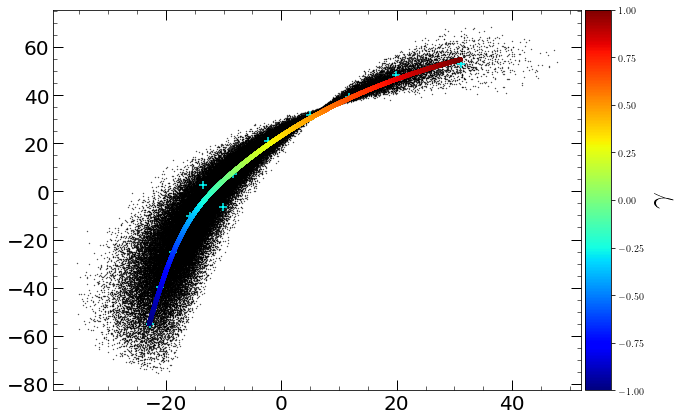

In [4]:
import pickle
neval_scipy = len(x_stream)*3 # For plotting purposes; oversample
gamma_points = torch.linspace(-1,1,len(x_binned)).float()
gamma_eval_scipy = np.linspace(-1,1,neval_scipy)

s = 1*200#1000#400 #200
x_scipy_spline = splrep(gamma_points.numpy(), x_binned,k=3,s=s)#UnivariateSpline(gamma_points.numpy(), x_binned,k=3)
z_scipy_spline = splrep(gamma_points.numpy(), z_binned,k=3,s=s)#UnivariateSpline(gamma_points.numpy(), z_binned,k=3)

x_scipy_out = splev(gamma_eval_scipy, x_scipy_spline)#x_scipy_spline(gamma_eval_scipy)
z_scipy_out = splev(gamma_eval_scipy, z_scipy_spline)#z_scipy_spline(gamma_eval_scipy)

fig, ax = plt.subplots(1,1)
from matplotlib import rc
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
for i in range(1):
    ax.tick_params(which='major',labelsize = 20,direction='in', length=10, width=1, colors='k',top=True,right=True) #Major
    ax.minorticks_on() #Minor
    ax.tick_params(which='minor',direction='in',top=True,right=True, length=4) #Minor

fig.set_size_inches(10,7)
ax.scatter(x_stream,z_stream,rasterized=True,color='k',s=0.1)
ax.scatter(x_binned,z_binned,color='cyan',s=50,alpha=1,marker='+')
gamma_eval_scipy_rescaled = np.linspace(-1,1,len(gamma_eval_scipy))
cmap = ax.scatter(x_scipy_out, z_scipy_out,c=gamma_eval_scipy_rescaled,alpha=1,facecolor='pink',s=10,cmap=plt.get_cmap('jet'),
          marker='o')#,ls='-')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(cmap, cax=cax, orientation='vertical')
cax.set_ylabel('$\gamma$', fontsize=30)


save_arr = [x_stream,z_stream,x_binned,z_binned,gamma_eval_scipy_rescaled,x_scipy_out,z_scipy_out]
####np.save('DataStreamPlot_q'+ str(q) + "_time_" + str(time)  ,save_arr)


#ax.legend(fontsize=20)
#####pickle.dump(ax, open("stream_plot_q_" + str(q) + "_time_" + str(time) + ".pickle", "wb"))

In [5]:
stream_pos = np.vstack([x_stream,z_stream]).T
spline_pos = np.vstack([x_scipy_out, z_scipy_out]).T
gamma_star = np.zeros(len(stream_pos))
for i in tqdm(range(len(x_stream))):
    dist_square = np.sum( (stream_pos[i,:] - spline_pos)**2, axis=1 )
    gamma_star[i] = gamma_eval_scipy[np.argmin(dist_square)]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [169]:
save_arr = [gamma_star,dist_square]
#np.save('Data_distsquare_gamma_star'+ str(q) + "_time_" + str(time)  ,save_arr)


/Users/jnibauer/opt/anaconda3/envs/MachineLearnGravPotential/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



Text(0, 0.5, '$\\gamma$')

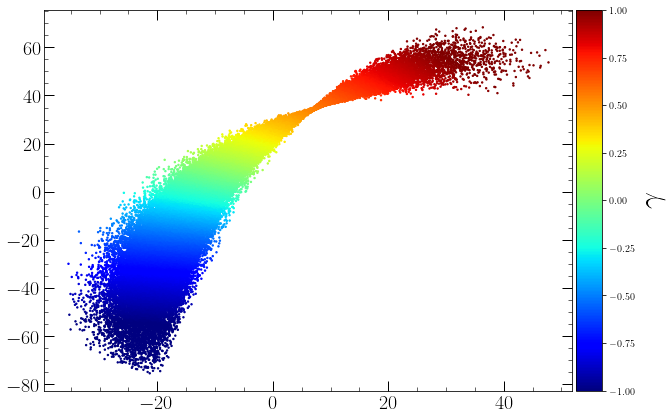

In [6]:
fig, ax = plt.subplots(1,1)
from matplotlib import rc
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
for i in range(1):
    ax.tick_params(which='major',labelsize = 20,direction='in', length=10, width=1, colors='k',top=True,right=True) #Major
    ax.minorticks_on() #Minor
    ax.tick_params(which='minor',direction='in',top=True,right=True, length=4) #Minor

fig.set_size_inches(10,7)
cmap = ax.scatter(x_stream,z_stream,rasterized=True,c=gamma_star,s=2,cmap=plt.get_cmap('jet'))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(cmap, cax=cax, orientation='vertical')
cax.set_ylabel('$\gamma$', fontsize=30)



In [7]:
uniq_gamm, index, count = np.unique(gamma_star,return_counts=True,return_index=True)
x_stream_use = x_stream[index]
z_stream_use = z_stream[index]

repeat_gamm = uniq_gamm[count > 1]
x_bar = np.zeros(len(repeat_gamm))
z_bar = np.zeros(len(repeat_gamm))

for i in tqdm(range(len(repeat_gamm))):
    x_bar[i] = np.mean(x_stream[gamma_star == repeat_gamm[i]])
    z_bar[i] = np.mean(z_stream[gamma_star == repeat_gamm[i]])
    
    
skip = 2
x_stream_use[count>1] = x_bar
z_stream_use[count>1] = z_bar
gamma_use = gamma_star[index]

x_stream_use = x_stream_use[::skip]
z_stream_use = z_stream_use[::skip]
gamma_use = gamma_use[::skip]
print(gamma_use.shape)



  0%|          | 0/13782 [00:00<?, ?it/s]

(41251,)


In [30]:

s = 1e6#400 #200

x_scipy_spline = splrep(gamma_use, x_stream_use,k=3,s=s)#UnivariateSpline(gamma_points.numpy(), x_binned,k=3)
z_scipy_spline = splrep(gamma_use, z_stream_use,k=3,s=s)#UnivariateSpline(gamma_points.numpy(), z_binned,k=3)

gamma_eval_scipy = np.linspace(gamma_use.min(),gamma_use.max(),500)

x_scipy_out = splev(gamma_eval_scipy, x_scipy_spline)#x_scipy_spline(gamma_eval_scipy)
z_scipy_out = splev(gamma_eval_scipy, z_scipy_spline)#z_scipy_spline(gamma_eval_scipy)


Text(0, 0.5, '$\\gamma$')

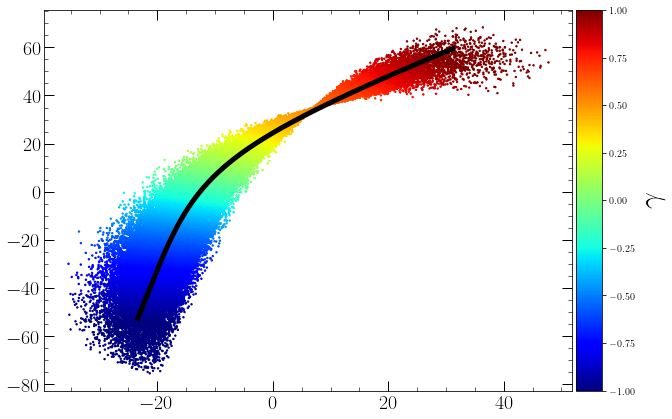

In [31]:
import pickle

fig, ax = plt.subplots(1,1)
from matplotlib import rc
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
for i in range(1):
    ax.tick_params(which='major',labelsize = 20,direction='in', length=10, width=1, colors='k',top=True,right=True) #Major
    ax.minorticks_on() #Minor
    ax.tick_params(which='minor',direction='in',top=True,right=True, length=4) #Minor

fig.set_size_inches(10,7)
cmap = ax.scatter(x_stream,z_stream,rasterized=True,c=gamma_star,s=2,cmap=plt.get_cmap('jet'))
ax.plot(x_scipy_out,z_scipy_out,color='k',lw=5,alpha=1)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(cmap, cax=cax, orientation='vertical')
cax.set_ylabel('$\gamma$', fontsize=30)

#####save_arr = [x_stream,z_stream,x_binned,z_binned,gamma_eval_scipy_rescaled,x_scipy_out,z_scipy_out]
#np.save('DataStreamPlot_q'+ str(q) + "_time_" + str(time)  ,save_arr)

#ax.legend(fontsize=20)
####pickle.dump(ax, open("stream_plot_q_" + str(q) + "_time_" + str(time) + ".pickle", "wb"))

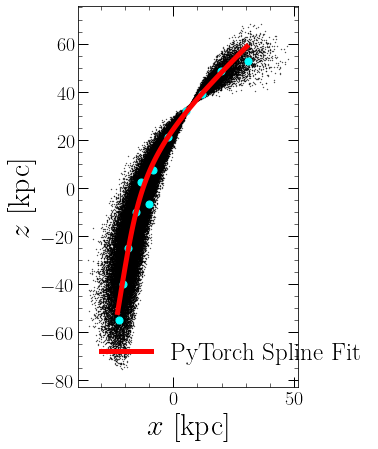

In [32]:
neval_torch = 50 #Simple curve; we'll use more points along path
gamma_points = torch.tensor(gamma_eval_scipy).float() 
gamma_eval = torch.linspace(-.99,.99,neval_torch).float() #.98
sorted_xz = torch.vstack([ torch.tensor(x_scipy_out), torch.tensor(z_scipy_out) ]).T.float()

gamma_eval.requires_grad = True
x_out = spline.interp(gamma_points, sorted_xz[:,0], gamma_eval)
z_out = spline.interp(gamma_points, sorted_xz[:,1], gamma_eval)

fig, ax = plt.subplots(1,1)
from matplotlib import rc
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
for i in range(1):
    ax.tick_params(which='major',labelsize = 20,direction='in', length=10, width=1, colors='k',top=True,right=True) #Major
    ax.minorticks_on() #Minor
    ax.tick_params(which='minor',direction='in',top=True,right=True, length=4) #Minor

fig.set_size_inches(10,7)
ax.scatter(x_stream,z_stream,rasterized=True,color='k',s=0.1)
ax.scatter(x_binned,z_binned,color='cyan',s=50)
ax.plot(x_out.detach().numpy(),z_out.detach().numpy(),lw=5,color='r',alpha=1,label='PyTorch Spline Fit',ls='-')

ax.set_xlabel(r'$x$ [kpc]',fontsize=30)
ax.set_ylabel(r'$z$ [kpc]',fontsize=30)
ax.set_aspect('equal')
ax.legend(frameon=False,fontsize=25)
#plt.savefig('StreamModel_SplineFit.pdf')

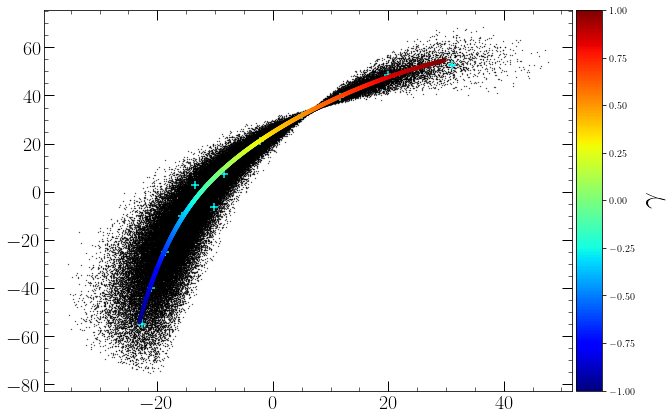

In [25]:
gamma_eval_curr = torch.linspace(gamma_eval.min().detach(),gamma_eval.max().detach(),1000)
x_Plot = spline.interp(gamma_points, sorted_xz[:,0],gamma_eval_curr)
z_Plot = spline.interp(gamma_points, sorted_xz[:,1], gamma_eval_curr)

fig, ax = plt.subplots(1,1)
from matplotlib import rc
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
for i in range(1):
    ax.tick_params(which='major',labelsize = 20,direction='in', length=10, width=1, colors='k',top=True,right=True) #Major
    ax.minorticks_on() #Minor
    ax.tick_params(which='minor',direction='in',top=True,right=True, length=4) #Minor

fig.set_size_inches(10,7)
ax.scatter(x_stream,z_stream,rasterized=True,color='k',s=0.1)
ax.scatter(x_binned,z_binned,color='cyan',s=50,alpha=1,marker='+')
gamma_eval_rescaled = np.linspace(-1,1,len(gamma_eval_curr))
cmap = ax.scatter(x_Plot.numpy(), z_Plot.numpy(),c=gamma_eval_rescaled,alpha=1,facecolor='pink',s=10,cmap=plt.get_cmap('jet'),
          marker='o')#,ls='-')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(cmap, cax=cax, orientation='vertical')
cax.set_ylabel('$\gamma$', fontsize=30)


save_arr = [x_stream,z_stream,x_Plot.numpy(),z_Plot.numpy(),gamma_eval_rescaled]
##np.save('DataStreamPlot_q'+ str(q) + "_time_" + str(time)  ,save_arr)


#ax.legend(fontsize=20)
#####pickle.dump(ax, open("stream_plot_q_" + str(q) + "_time_" + str(time) + ".pickle", "wb"))

In [26]:
## We generically use x and y for variables here. The true coordinates in this case are (x,z) for our frame
dx_dgamma = torch.autograd.grad(inputs=gamma_eval, outputs=x_out.sum(),create_graph=True)[0]
dy_dgamma = torch.autograd.grad(inputs=gamma_eval, outputs=z_out.sum(),create_graph=True)[0]
Tang_vec = torch.vstack([dx_dgamma,dy_dgamma]).T
T_hat = Tang_vec/( torch.sqrt( torch.sum( Tang_vec**2, dim=1 ) )[:,None] )
d_T_hat_x_dgamma = torch.autograd.grad(T_hat[:,0].sum(),inputs=gamma_eval,create_graph=True)[0]
d_T_hat_y_dgamma = torch.autograd.grad(T_hat[:,1].sum(),inputs=gamma_eval,create_graph=True)[0]
d_T_hat_dgamma = torch.vstack([d_T_hat_x_dgamma,d_T_hat_y_dgamma]).T
d_T_hat_dgamma_over_mag = d_T_hat_dgamma/( torch.sqrt( torch.sum( d_T_hat_dgamma**2, dim=1 ) )[:,None] )

alpha = T_hat[:,0]*T_hat[:,1]
c_x = 1.0 - T_hat[:,0]**2
c_y = 1.0 - T_hat[:,1]**2
q_x = d_T_hat_dgamma_over_mag[:,0]
q_y = d_T_hat_dgamma_over_mag[:,1]

a_tilde_unit_pred = d_T_hat_dgamma_over_mag.detach().numpy()
a_tilde_unit_pred.shape

instant_tang = torch.vstack([T_hat[:,1], -T_hat[:,0]]).T

T_x = T_hat.detach().numpy()[:,0]
T_y = T_hat.detach().numpy()[:,1]


ETA = np.sign(torch.sum(d_T_hat_dgamma_over_mag*instant_tang,dim=1).detach().numpy())

mag_d_T_hat_dgamma = ( torch.sqrt( torch.sum( d_T_hat_dgamma**2, dim=1 ) )).detach().numpy()

no_change_bool = mag_d_T_hat_dgamma < .05
print(no_change_bool.sum())

0


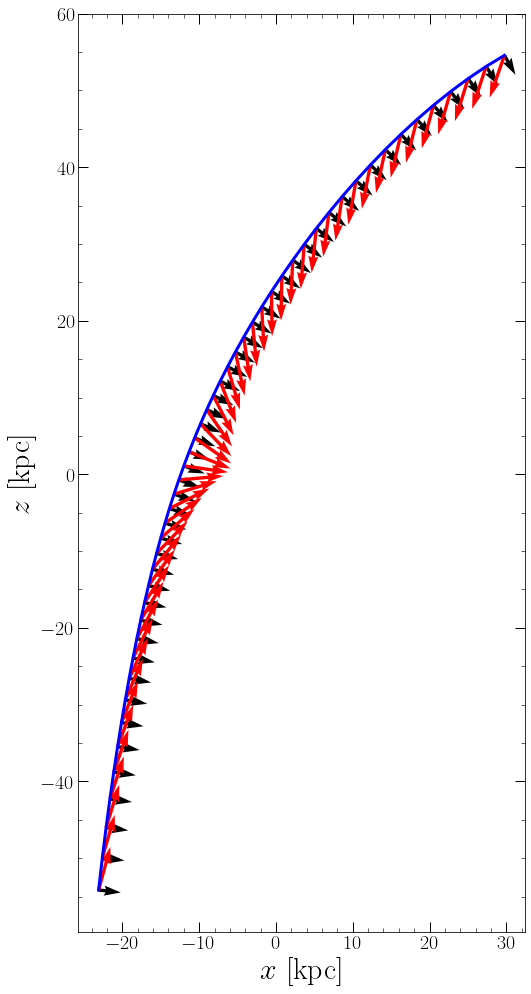

In [27]:
q_trial = q#.5
mass_ratio_trial = 1.#1000.#10**3.08720342
pot_trial = MainFunctions.get_trial_pot(q=q_trial,mass_halo_disk_ratio=mass_ratio_trial,origin=np.array([0,0]))
inp = np.vstack([x_out.detach().numpy(), np.zeros_like(x_out.detach().numpy()) ,z_out.detach().numpy()])
acc_trial = pot_trial.acceleration(inp*u.kpc)
x_dot_dot = acc_trial[0,:].value/np.sqrt( acc_trial[0,:].value**2 + acc_trial[2,:].value**2)[None,:]
y_dot_dot = acc_trial[2,:].value/np.sqrt( acc_trial[0,:].value**2 + acc_trial[2,:].value**2)[None,:]


import matplotlib.pylab as pl

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,20)
from matplotlib import rc
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
for i in range(1):
    ax.tick_params(which='major',labelsize = 20,direction='in', length=10, width=1, colors='k',top=True,right=True) #Major
    ax.minorticks_on() #Minor
    ax.tick_params(which='minor',direction='in',top=True,right=True, length=4) #Minor


ax.plot(x_out.detach(),z_out.detach(),color='blue',lw=3)
s = 1
ax.quiver(x_out[::s].detach(),z_out[::s].detach(),d_T_hat_dgamma_over_mag[::s,0].detach(),d_T_hat_dgamma_over_mag[::s,1].detach(),scale=20)

ax.quiver(x_out[::s].detach(),z_out[::s].detach(),x_dot_dot,y_dot_dot,color='r',scale=10)


ax.quiver(x_out[no_change_bool].detach(),z_out[no_change_bool].detach(),d_T_hat_dgamma_over_mag[no_change_bool,0].detach(),d_T_hat_dgamma_over_mag[no_change_bool,1].detach(),
          color='g',scale=10)


ax.set_xlabel(r'$x$ [kpc]',fontsize=30)
ax.set_ylabel(r'$z$ [kpc]',fontsize=30)
ax.set_aspect('equal')

###plt.savefig('Stream_ExampleWithNOChangeInTangent.pdf')


In [20]:
q_trial = np.linspace(.1,3.2,1000)
inp = np.vstack([ x_out.detach().numpy(),np.zeros(len(x_out))+0,z_out.detach().numpy()])
log_like_arr_with_tang = np.zeros(len(q_trial))
log_like_arr_without_tang = np.zeros(len(q_trial))

for i in tqdm(range(len(q_trial))):
    q_curr = q_trial[i]
    pot_trial =MainFunctions.get_trial_pot(q=q_curr)
    acc_trial = pot_trial.acceleration(inp*u.kpc).T[:,:].value
    acc_trial_planar = np.vstack([acc_trial[:,0], acc_trial[:,2]]).T
    acc_trial_planar_unit = acc_trial_planar / (np.sqrt(np.sum(acc_trial_planar**2,axis=1))[:,None]) 
    f_less, f_gtr, f0, kappa_undef_bool = MainFunctions.get_your_fractions(d_T_hat_dgamma_over_mag.detach().numpy(),  d_T_hat_dgamma.detach().numpy(),
                       acc_trial_planar_unit, thresh_f0 = .05)
    # Correct fraction due to removal of undefined points. The number of points in the analysis changes.
    f_less = f_less*len(x_out)/(len(x_out) - kappa_undef_bool.sum())
    f_gtr = f_gtr*len(x_out)/(len(x_out) - kappa_undef_bool.sum())
    log_like_arr_without_tang[i] = MainFunctions.log_like(len(x_out)-kappa_undef_bool.sum(),f_less, f_gtr, f0=f0, a_xy_hat = acc_trial_planar_unit[~kappa_undef_bool,:], 
         T_hat = T_hat.detach().numpy()[~kappa_undef_bool,:] , kappa_undef_bool=np.array([0]))
    
    
    f_less, f_gtr, f0, kappa_undef_bool = MainFunctions.get_your_fractions(d_T_hat_dgamma_over_mag.detach().numpy(),  d_T_hat_dgamma.detach().numpy(),
                       acc_trial_planar_unit, thresh_f0 = .05)

    log_like_arr_with_tang[i] = MainFunctions.log_like(len(x_out),f_less, f_gtr, f0=f0, a_xy_hat = acc_trial_planar_unit, 
         T_hat = T_hat.detach().numpy() , kappa_undef_bool=kappa_undef_bool)
    
    
    

  0%|          | 0/1000 [00:00<?, ?it/s]

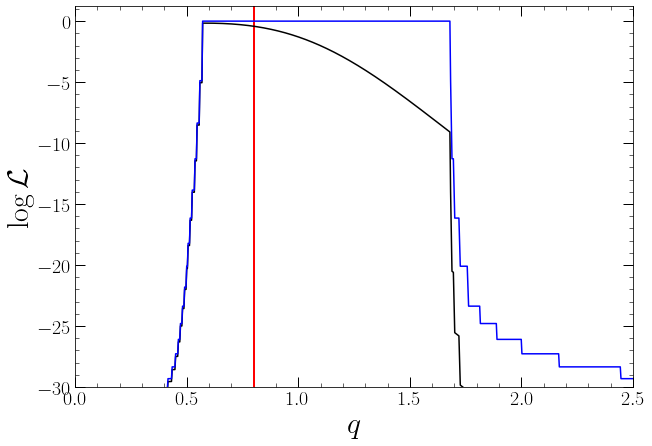

In [21]:
import matplotlib.pylab as pl

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)
from matplotlib import rc
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
for i in range(1):
    ax.tick_params(which='major',labelsize = 20,direction='in', length=10, width=1, colors='k',top=True,right=True) #Major
    ax.minorticks_on() #Minor
    ax.tick_params(which='minor',direction='in',top=True,right=True, length=4) #Minor

ax.plot(q_trial,log_like_arr_with_tang,color='k')
ax.plot(q_trial,log_like_arr_without_tang,color='blue',label='W/Out Tangent Condition')
ax.vlines(q,-30,1.4,lw=2,color='r',label='Truth')
#ax.legend(fontsize=25,frameon=False,loc='upper right')
ax.set_ylim(-30,1.2)
ax.set_xlim(0.,2.5)
ax.set_xlabel(r'$q$',fontsize=30)
ax.set_ylabel(r'$\log\mathcal{L}$',fontsize=30)
###pickle.dump(ax, open("LogL_plot_q_" + str(q) + "_time_" + str(time) + ".pickle", "wb"))
##plt.savefig('with_versus_without_tang_condition_samestreammodel.pdf')

save_arr = [q_trial,z_stream,log_like_arr_with_tang,log_like_arr_without_tang,q]
##np.save('DataLogLPlot_q'+ str(q) + "_time_" + str(time)  ,save_arr)


In [180]:
q_trial_n = np.linspace(.1,3.2,100)
inp = np.vstack([x_out[~kappa_undef_bool].detach().numpy(), np.zeros(len(gamma_eval[~kappa_undef_bool])), z_out[~kappa_undef_bool].detach().numpy()])
acc_stream_angle = np.zeros((len(q_trial_n),len(d_T_hat_dgamma_over_mag[~kappa_undef_bool])))

for i in tqdm(range(len(q_trial_n))):
    q_curr = q_trial_n[i]
    pot_trial = MainFunctions.get_trial_pot(q=q_curr)
    acc_trial = pot_trial.acceleration(inp*u.kpc).T[:,:].to(u.kpc/u.Gyr**2)
    xz_acc = np.vstack([acc_trial[:,0].value, acc_trial[:,2].value]).T
    xz_acc_unit = xz_acc / ( np.sqrt(np.sum( xz_acc**2 ,axis = 1 ))[:,None] )
    acc_stream_angle[i,:] = MainFunctions.get_acc_stream_angle(d_T_hat_dgamma_over_mag[~kappa_undef_bool].detach().numpy(), xz_acc_unit)
    
true_pot =  MainFunctions.get_trial_pot(q=q)
acc_true = true_pot.acceleration(inp*u.kpc).value.T[:,:]
xz_acc_true = np.vstack([acc_true[:,0], acc_true[:,2]]).T
xz_acc_unit_true = xz_acc_true / ( np.sqrt(np.sum( xz_acc_true**2 ,axis = 1 ))[:,None] )
acc_stream_angle_true = MainFunctions.get_acc_stream_angle(d_T_hat_dgamma_over_mag[~kappa_undef_bool,:].detach().numpy(), xz_acc_unit_true)

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/jnibauer/opt/anaconda3/envs/MachineLearnGravPotential/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)



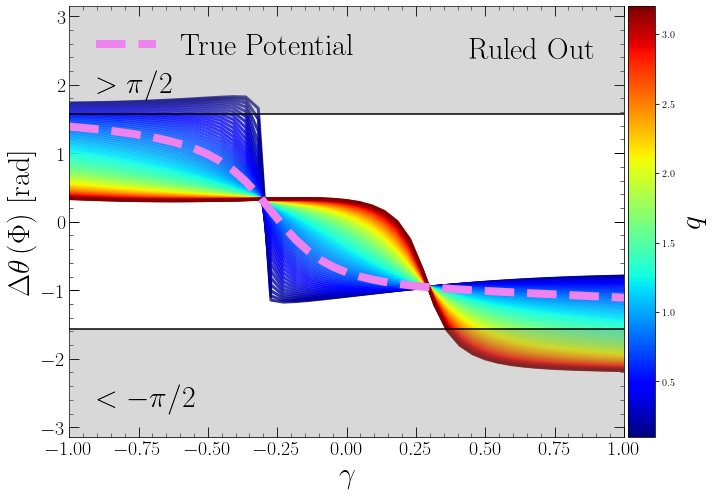

In [182]:
scale_fac = 1e10
ylim = .0003
legend_loc = 'upper left'

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)
from matplotlib import rc
import matplotlib as mpl
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import ImageGrid
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
for i in range(1):
    ax.tick_params(which='major',labelsize = 20,direction='in', length=10, width=1, colors='k',top=True,right=True) #Major
    ax.minorticks_on() #Minor
    ax.tick_params(which='minor',direction='in',top=True,right=True, length=4) #Minor



q_test = np.copy(q_trial_n)#np.linspace(.1,2.5,10)
n = len(q_test)
cc = np.copy(q_test)
colors = pl.cm.jet(np.linspace(0,1,n)) #pl.cm.jet(cc)

norm = mpl.colors.Normalize(vmin=cc.min(), vmax=cc.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
#cmap.set_array([])
gamma_temp = np.linspace(-1,1,len(gamma_eval[~kappa_undef_bool].detach().numpy()))#gamma_eval.detach().numpy()#np.linspace(-1,1,len(x))

for i in range(len(q_test)):
    _ = ax.plot(gamma_temp,acc_stream_angle[i,:],rasterized=False,lw=3,alpha=.8,color=colors[i])
#ax.plot(gamma_temp,ratio_data,rasterized=False,color='k',lw=3,ls='--',label='$T_x/T_y$')
ax.plot(gamma_temp,acc_stream_angle_true,rasterized=False,color='violet',lw=8,ls='--',label='True Potential')

ax.set_xlabel(r'$\gamma$',fontsize=30)
ax.set_ylabel(r'$\Delta \theta \left(\Phi\right)$ [rad]',fontsize=30)


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(cmap, cax=cax, orientation='vertical')
cax.set_ylabel('$q$', fontsize=30)
###ax.hlines(0,np.pi/2,10,color='k',zorder=3)

ax.fill_between(gamma_temp,np.repeat(np.pi/2,len(gamma_temp)),10*np.ones_like(gamma_temp),facecolor='grey',alpha=.3,zorder=3)#,label='Ruled Out')
ax.fill_between(gamma_temp,-np.repeat(np.pi/2,len(gamma_temp)),-10*np.ones_like(gamma_temp),facecolor='grey',alpha=.3,zorder=3)#,label='Ruled Out')
ax.hlines(np.pi/2,-10,10,color='k',zorder=3)
ax.hlines(-np.pi/2,-10,10,color='k',zorder=3)

#plt.tight_layout()
####ax.set_ylim(-.01,.01)
##########ax[1].set_ylim(-ylim,ylim)
ax.set_xlim(gamma_temp.min(),gamma_temp.max())
ax.legend(fontsize=30,frameon=False,loc=legend_loc)
ax.text(.72,.88,'Ruled Out',fontsize=30,color='k',
          transform=ax.transAxes)

ax.text(.05,.8,r'$> \pi/2$',fontsize=30,color='k',
          transform=ax.transAxes)
ax.text(.05,.07,r'$< -\pi/2$',fontsize=30,color='k',
          transform=ax.transAxes)

ax.set_ylim(-np.pi,np.pi)
#ax[1].text(.07,.85,'Ruled Out',fontsize=30,color='k',path_effects=[pe.withStroke(linewidth=1, foreground="k")],
#         transform=ax[1].transAxes)
plt.tight_layout()
save_arr = [q_test,gamma_temp,acc_stream_angle.flatten(),acc_stream_angle_true]
#####np.save('DataPlot_DeltaTheta'+ str(q) + "_time_" + str(time)  ,save_arr)

#ax.set_xlim(-.99,.99)
##plt.savefig('Potential_Constraint.pdf')
####pickle.dump(ax, open("DeltaTheta_plot_q_" + str(q) + "_time_" + str(time) + ".pickle", "wb"))